In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from numba import njit
from cmath import exp

In [3]:
@njit#(parallel=True)
def ThetaFunction(z: np.complex128, t: np.complex128, a: np.float64,
                  b: np.float64, n_max: np.uint32 = 1000
                  ) -> np.complex128:
    index = np.arange(-n_max, n_max, 1)
    x = t*a + 2*(z+b)
    terms = np.exp(1j*np.pi*(index+a)*(t*index + x))
    return np.sum(terms)

## How many theta functon terms to converge to machine precision

In [34]:
N = 60
x, y = np.meshgrid(np.linspace(-2,2,N), np.linspace(-2,2,N), indexing='xy')
z = x + 1j*y
tf_grid_1 = np.zeros((N,N), dtype=np.complex128)
tf_grid_2 = np.zeros((N,N), dtype=np.complex128)

for i in range(N):
    for j in range(N):
        tf_grid_1[i,j] = ThetaFunction(z[i,j], 1j, 1/2, 1/2,6)
        tf_grid_2[i,j] = ThetaFunction(z[i,j], 1j, 1/2, 1/2,11)

In [35]:
ThetaFunction(-0.5-0.5*1j, 1j, 1/2, 1/2,2500)

(2.3828557978614704+0j)

In [36]:
np.sum(np.real(tf_grid_1-tf_grid_2)**2)

0.0

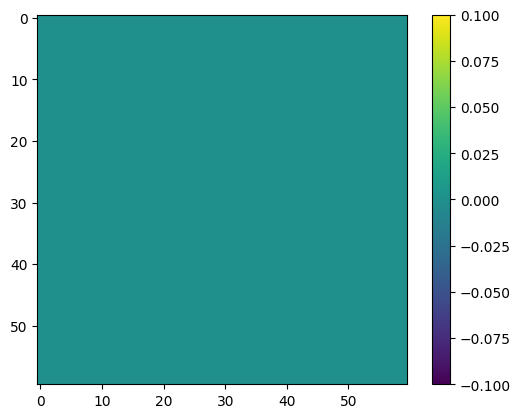

In [37]:
plt.imshow(np.real(tf_grid_1-tf_grid_2))
plt.colorbar()

In [43]:
#@jit#(parallel=True)
def TF1(z: np.complex128, t: np.complex128, a: np.float64,
                  b: np.float64, n_max: np.uint32 = 50
                  ) -> np.complex128:
    s=0
    x = t*a + 2*(z+b)
    for i in range(-n_max, n_max, 1):
        s += exp(1j*np.pi*(i+a)*(t*i + x))
    
    return s

In [42]:
%%timeit

ThetaFunction(0.5+1*1j, 1j, 1/2, 1/2, 10)

693 ns ± 1.18 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [45]:
%%timeit
TF1(0.5+0.5*1j, 1j, 1/2, 1/2, 10)

5.84 µs ± 51.8 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [51]:
ThetaFunction(0.5+0.5*1j, 1j, 1/2, 1/2)

(-2.3828557978614704-2.9181567256807615e-16j)

In [47]:
ThetaFunction(0.5+0.5*1j, 1j, 1/2, 1/2)

(-2.3828557978614704-2.9181567256807615e-16j)